In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Set plot style for better visuals (optional)
# plt.style.use('ggplot')

In [25]:
# 1. Load Data
df = pd.read_csv('../DataSets/50_Startups.csv')
df.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [26]:
# 2. Define Features (X) and Target (y)
# We do this FIRST, on the raw, un-scaled data.
X = df.drop('Profit', axis=1) # X is everything except the target
y = df['Profit']             # y is just the target

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (50, 4)
Shape of y: (50,)


In [27]:
# 3. Split the data
# This is the MOST IMPORTANT first step after defining X and y.
# We split the raw data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

Training samples: 40
Testing samples: 10


In [28]:
# 4. Define Preprocessing

# Identify which columns are which type
numeric_features = ['R&D Spend', 'Administration', 'Marketing Spend']
categorical_features = ['State']

# Create a "transformer" for numeric columns
# It will apply StandardScaler
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Create a "transformer" for categorical columns
# It will apply OneHotEncoder and drop one category (to avoid dummy variable trap)
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder())
])
# categorical_transformer = Pipeline(steps=[
#     ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
# ])

# Use ColumnTransformer to combine these two transformers
# It will apply the right transformer to the right columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough') # Keep any other columns (though we don't have any here)

print(preprocessor)

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['R&D Spend', 'Administration',
                                  'Marketing Spend']),
                                ('cat',
                                 Pipeline(steps=[('onehot', OneHotEncoder())]),
                                 ['State'])])


In [29]:
# 5. Create the Full Model Pipeline
# This pipeline first runs the preprocessor, then runs the model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

print(model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['R&D Spend',
                                                   'Administration',
                                                   'Marketing Spend']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['State'])])),
                ('regressor', LinearRegression())])


In [30]:
# 6. Train the Model
# We fit the *entire* pipeline on the raw X_train and y_train.
# Scikit-learn automatically handles all the fitting and transforming
# *only* on the training data. No leakage!
model.fit(X_train, y_train)

print("Model trained successfully!")

Model trained successfully!


In [31]:
# 7. Make Predictions
# We predict on the raw X_test. The pipeline automatically
# applies the *already-fitted* transformations.
y_pred = model.predict(X_test)

# Show the first 5 predictions vs actuals
pd.DataFrame({'Actual Profit': y_test, 'Predicted Profit': y_pred}).head()

,Actual Profit,Predicted Profit
13,134307.35,126362.879083
39,81005.76,84608.453836
30,99937.59,99677.494252
45,64926.08,46357.460686
17,125370.37,128750.482885


In [32]:
# 8. Evaluate Metrics (on the *original* scale)
# Since we never scaled y, our y_test and y_pred are already
# in the correct, interpretable units (e.g., Dollars).

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print(f"R-squared (R2): {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

R-squared (R2): 0.8987
Mean Absolute Error (MAE): 6961.48
Mean Squared Error (MSE): 82010363.05
Root Mean Squared Error (RMSE): 9055.96


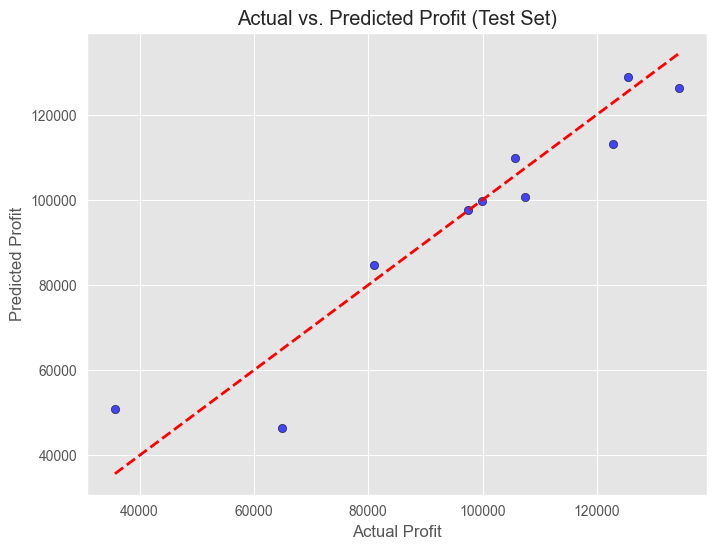

In [33]:
# 9. Correct Visualization
# A scatter plot of actual vs. predicted is the standard.

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, edgecolors='k', color='blue')
# Plot the "perfect prediction" line
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Profit")
plt.ylabel("Predicted Profit")
plt.title("Actual vs. Predicted Profit (Test Set)")
plt.grid(True)
plt.show()

In [34]:
# 10. Inspect Coefficients (Optional)
# This is how you see the coefficients from the pipeline

# Get the regressor step from the pipeline
regressor = model.named_steps['regressor']
# Get the preprocessor step
preprocessor = model.named_steps['preprocessor']

# Get the feature names from the preprocessor
# This finds the names from the 'cat' transformer's 'onehot' step
cat_features = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)

# Combine the numeric feature names and the new categorical feature names
all_features = numeric_features + list(cat_features)

# Print coefficients
print("\n--- Model Coefficients ---")
print(f"Intercept: {regressor.intercept_:.2f}")

# Create a nice series for easy reading
pd.Series(regressor.coef_, index=all_features).sort_values(ascending=False)


--- Model Coefficients ---
Intercept: 115636.13


R&D Spend           38102.269270
Marketing Spend      3386.175807
State_Florida         623.532751
State_New York       -308.272495
State_California     -315.260255
Administration      -1864.754300
dtype: float64